In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
import dask.dataframe as dd
from timeit import default_timer as tic
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
import dask_ml.cluster

C:\Users\chime\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Create cluster with fixed number of workers, equal to 2

In [1]:
client = Client('ip:port')#, n_workers=2, threads_per_worker=1)
display(client)

NameError: name 'Client' is not defined

### 2. Load the remote dataset

In [3]:
# Dictionary to better specify the feature variable types
types = {'pixel_'+str(i) : float for i in range(1, 785)}

df = dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1',
                dtype = types)
df=client.persist(df)
print('There are '+str(len(df))+' records in the dataset!')

There are 50000 records in the dataset!


### 3. Count the number of examples for each alphabet character and plot them

In [4]:
%%time
sdf = df.groupby('letter').letter.count().compute()

Wall time: 157 ms


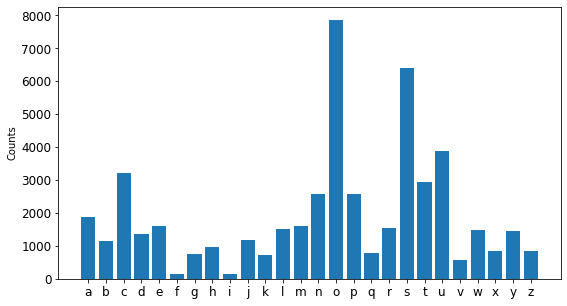

In [5]:
#Plot
plt.figure(figsize=(9,5)); ax = plt.axes()
ax.bar(sdf.index.values, sdf.values)
ax.set_ylabel("Counts", fontsize=10)
ax.tick_params(labelsize=12)
plt.show()

### 4. Record the time necessary to accomplish the previous point with different repartitions of data

The time needed to compute the result is very variable, probably due to different reasons. The actual representative data was computed as the mean over 5 identical iterations to make them more stabile and show underlying behaviours. Unfortunately 5 was a reasonable number considering some problems encountered because of the poor wifi connection representing a bottleneck for machine communication. Probably a LAN network would give more reliable results.

Worst=3; Best=2
Worst=7; Best=1
Worst=3; Best=1
Worst=6; Best=2
Worst=8; Best=1


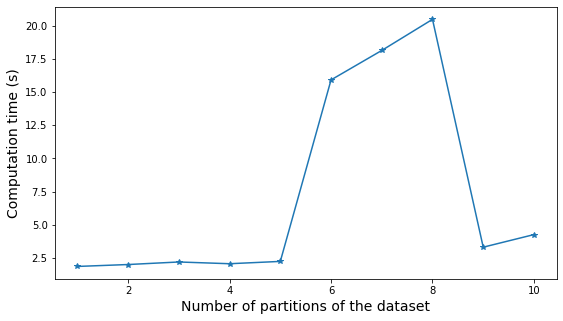

In [6]:
# Initialize the partitionings and the number of measurements for the mean
partitions = range(1,11)
n_mean = 5
timings = np.zeros([(len(partitions))])
old_timings = timings

for i in np.arange(n_mean):
    for i, val in enumerate(partitions):
        df = df.repartition(npartitions=val)
        t1=tic()
        sdf = df.groupby('letter').count().compute()
        t2=tic()
        old_timings[i]=t2-t1
    print('Worst='+str(partitions[np.argmax(timings)])+'; Best='+str(partitions[np.argmin(timings)]))
    timings += old_timings
timings = timings/n_mean

np.savetxt('data/2_w_part.txt', timings)

#Plot
plt.figure(figsize=(9,5)); ax=plt.axes()
ax.plot(partitions, timings, marker='*')
ax.set_xlabel('Number of partitions of the dataset', fontsize=14)
ax.set_ylabel('Computation time (s)', fontsize=14)
plt.show()

The computation time seems to tend to be lower for 1-2 partitions and fluctuate for higer number.
Considering that Dask suggests to create data partition of the size of 100MB then our dataset should be stored in one partition or two for best performance. However depending on the number of the available workers this might change. Having too many workers accessing the data in the same few locations might slow down the processes running on the cluster. (see point 8.)

### 5. Filter the data in order to get a subsampled dataset that contains only rows for character 'a' and 'z'

In [7]:
df = df.repartition(npartitions=2)

subdf = df[df['letter'].isin(['a','z'])]
subdf.visualize(rankdir='LR')

The Graph shows all the iterations in the repartitioning loop. In the following we replot only the subsampling part by reloading the dataset object.

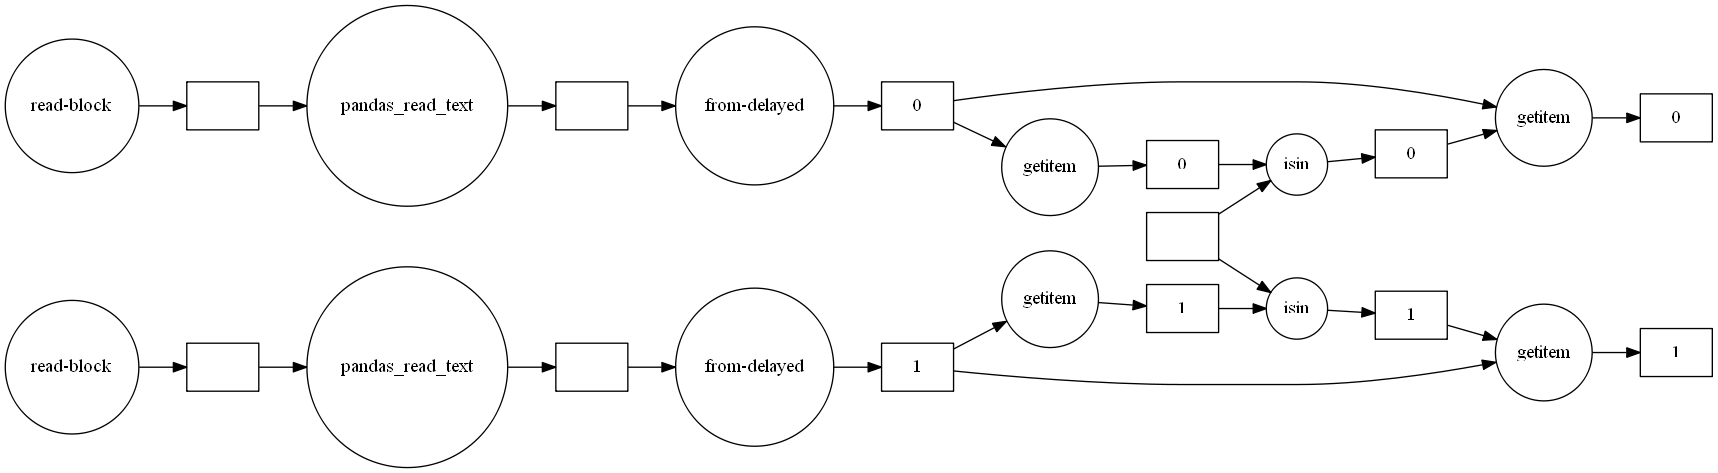

In [8]:
data = dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1',
                dtype = types)
sub = data[data['letter'].isin(['a','z'])]
sub.visualize(rankdir='LR')

By looking at one of the last stages, where the method .isin is called it is interesting to note that both workers seem to access to both their chunk of data (previously separed) and the whole dataset. This behaviour is probably due to the nested syntax used for the dataset filtering procedure. 

### 6. Take the subsampled dataset and divide it in training (80%) and test (20%) sets.

In [9]:
subdf = subdf.drop('letter', axis=1)

In [10]:
y = subdf.label.to_dask_array(lengths=True)
x = subdf.drop('label', axis=1).to_dask_array(lengths=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)

### 7. Use the MinMaxScaler with IncrementalLearning, MLPClassifier and ParallelPostFit in order to training and test a simple neural network over the cluster

In [11]:
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(x_train)

x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)

#Multilayer Linear Perceptron
estimator = MLPClassifier(random_state=42, 
                          max_iter=1000, 
                          hidden_layer_sizes=(200, 200), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
t1 = tic()
clf = Incremental(estimator)
clf.fit(x, y, classes=[0, 25])
clf = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
t2 = tic()
print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, clf.predict(x_test))))
print("Time: "+str(t2-t1)+"s")

results = [dask_ml.metrics.accuracy_score(y_test, clf.predict(x_test)), t2-t1]
np.savetxt('data/2_w_MLP.txt', results)

Accuracy: 0.977818853974122
Time: 424.0764636000001s


As we can see the MultilayerPerceptron has a very high score. This result varies very little when compared with the ones obtained using higher numbers of workers. However these kind of results must be tested on new data to actually check their performance since a high accuracy might be releated to an overfitting problem,however the pursue of the best optimization was not taken into consideration here.

### 8. Repeat from point 1 to point 7 changing the number of workers to 4, 6, 8, 10 (larger number of workers must be implemented with multiple machines ( >= 6 )). Compare the results and the times and explain the behavior.

The same code as written above was run using higher number of cores. In order to maintain some uniformity among the different tries, both the number of threads per worker and the maximum RAM were specified in the command line with:
>> \>\>dask-worker  schedulerIP:Port  --nprocs n  --nthreads 2  --memory-limit 4GB

Then both the execution times of point 3. and the scores of point 7. have been recorded on separate text file.

Since the data files were stored on one machine only, in the next cell we use pandas to load them instead of dask.distributed. This was done cause the datasets are very small and dask.distributed incurred into some issues due to the data physical location.

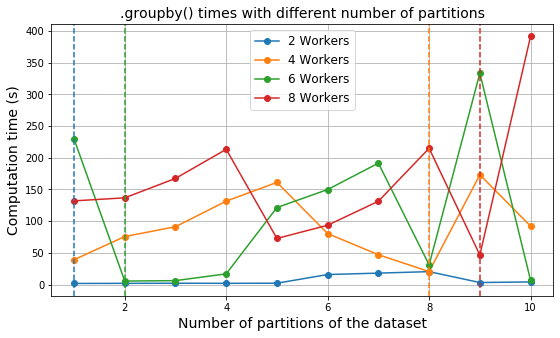

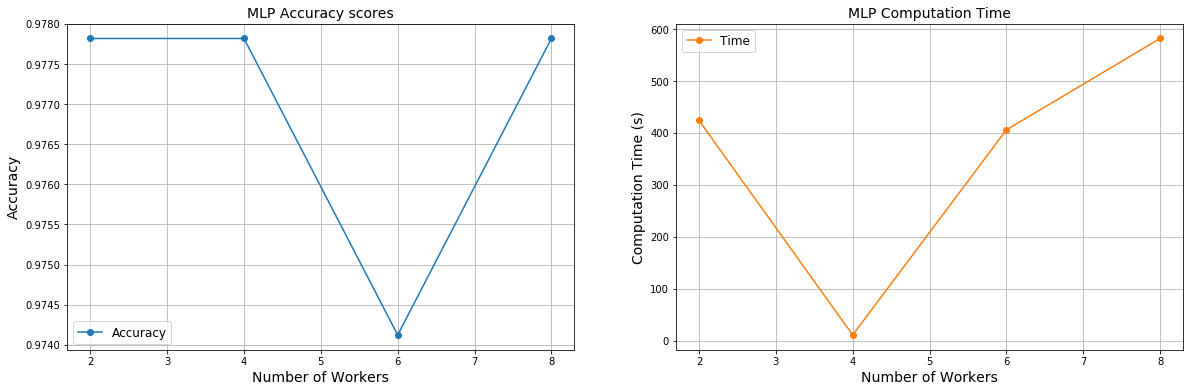

In [32]:
import pandas as pd
# Load Data
part2 = pd.read_csv('data/2_w_part.txt', header=None); MLP2 = pd.read_csv('data/2_w_MLP.txt', header=None);
part4 = pd.read_csv('data/4_w_part.txt', header=None); MLP4 = pd.read_csv('data/4_w_MLP.txt', header=None);
part6 = pd.read_csv('data/6_w_part.txt', header=None); MLP6 = pd.read_csv('data/6_w_MLP.txt', header=None);
part8 = pd.read_csv('data/8_w_part.txt', header=None); MLP8 = pd.read_csv('data/8_w_MLP.txt', header=None);

# Plot
#fig, ax = plt.subplots(figsize=(9,5))
plt.figure(figsize=(9,5)); ax=plt.axes()
ax.set_title('.groupby() times with different number of partitions', fontsize=14)
ax.plot(partitions, part2, marker='o', label="2 Workers")
ax.plot(partitions, part4, marker='o', label="4 Workers")
ax.plot(partitions, part6, marker='o', label="6 Workers")
ax.plot(partitions, part8, marker='o', label="8 Workers")
ax.axvline(partitions[np.argmin(part2)], color='C0', linestyle='--')
ax.axvline(partitions[np.argmin(part4)], color='C1', linestyle='--')
ax.axvline(partitions[np.argmin(part6)], color='C2', linestyle='--')
ax.axvline(partitions[np.argmin(part8)], color='C3', linestyle='--')
ax.set_xlabel('Number of partitions of the dataset', fontsize=14)
ax.set_ylabel('Computation time (s)', fontsize=14)
ax.legend(fontsize=12)
ax.grid()
plt.show()

#MLP results
MLP = pd.concat([MLP2,MLP4,MLP6,MLP8], axis=1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].set_title('MLP Accuracy scores', fontsize=14)
ax[1].set_title('MLP Computation Time', fontsize=14)
ax[0].plot(np.arange(2,10,2), MLP.iloc[0], marker='o', label="Accuracy")
ax[1].plot(np.arange(2,10,2), MLP.iloc[1], marker='o', label="Time", color='C1')
ax[0].set_xlabel('Number of Workers', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].set_xlabel('Number of Workers', fontsize=14)
ax[1].set_ylabel('Computation Time (s)', fontsize=14)
ax[1].legend(fontsize=12)
ax[0].grid(); ax[1].grid()
plt.show()

Unfortunately here we should keep in mind that the cluster used to run the analyses was composed by two machines with a total of 6 real cores and 12 threads and 24GB of RAM connected through a "not very performing" wifi network. For this reason the reliability of the results should be put into discussion.

The two-worker curve in the first plot shows a very different scale of variability. It was the only try performed using a single physical machine. With this we can quite confidently assert that the network speed highly impacted the computation times.

The MLP seems to perform well enough independently from the number of workers. However we see here that the computation time is much lower in the four-workers case. Here we remark that the MLP was run initializing the partitioning of the dataset to the number which scored best in the computation test performed in point 4. Given this we cannot associate the performing behaviour of the 4-worker configuration with the choice of a preferential data partitioning.

Tests should be run again on systems with ethernet connection for better reliability.

### Use the distributed Tensorflow. Use the MinMaxScaler with Convolutional Neural Network that you can find in the function “def build_deep_cnn_neural_network()” on the Notebook “Distributed Deep Learning on CPU-GPU”.

In [19]:
from dask_tensorflow import start_tensorflow
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

tf_spec, dask_spec = start_tensorflow(client, ps=2, worker=2)

In [20]:
x_train = x_train.reshape((len(x_train), 28,28, 1))
x_test = x_test.reshape((len(x_test),  28,28, 1))
y_train[y_train==25] = 1
y_test[y_test==25] = 1

In [21]:
def build_deep_cnn_neural_network():
    # create model
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), name='c', strides=(1, 1), padding='valid', activation='relu', input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='d'))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name='d1'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', name='d2'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
model = build_deep_cnn_neural_network()

model.fit(x_train.compute(), y_train.compute(), verbose=1, epochs=10, batch_size=32)
scores = model.evaluate(x_test.compute(),y_test.compute(), verbose=0)
print("Accuracy: "+str(scores[1]))

Epoch 1/10
2161/2161 [==============================] - 5s 3ms/step - loss: 0.0674 - accuracy: 0.9634
Epoch 2/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.0020 - accuracy: 0.9995
Epoch 3/10
2161/2161 [==============================] - 5s 2ms/step - loss: 4.3260e-04 - accuracy: 1.0000
Epoch 4/10
2161/2161 [==============================] - 5s 2ms/step - loss: 1.7036e-04 - accuracy: 1.0000
Epoch 5/10
2161/2161 [==============================] - 5s 2ms/step - loss: 9.6237e-05 - accuracy: 1.0000
Epoch 6/10
2161/2161 [==============================] - 6s 3ms/step - loss: 6.6526e-05 - accuracy: 1.0000
Epoch 7/10
2161/2161 [==============================] - 6s 3ms/step - loss: 4.7394e-05 - accuracy: 1.0000
Epoch 8/10
2161/2161 [==============================] - 6s 3ms/step - loss: 3.4899e-05 - accuracy: 1.0000
Epoch 9/10
2161/2161 [==============================] - 5s 2ms/step - loss: 2.7774e-05 - accuracy: 1.0000
Epoch 10/10
2161/2161 [==============================]